# pyTorch Convolutional Neural Networks (CNNs)

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import random
import PIL.Image as Image
from sklearn.metrics import confusion_matrix

### Torch vorbereiten

In [2]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## Aufgabe 1: Modelle laden
In diesem Notebook laden wir die drei vortrainierten Modelle aus dem Notebook *07_pytorch_convolution_FER.ipynb* um diese noch genauer auf ihre Performance zu untersuchen.

1. Wir müssen die Architektur der zwei eigenen Modelle definieren, damit wir die Gewichte laden können. Kopieren Sie die dazu die Definitionen der drei Modelle aus dem letzten Notebook hierher. Der Code ist bereits vorbereitet und gekennzeichnet.
2. Wir laden die drei Modelle mit den entsprechenden Gewichten, die Sie im letzten Notebook gespeichert haben. Der Code ist vorbereitet.

### Architektur-Definition Modell 1

In [3]:
model_1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*8*8, out_features=7),
)

### Architektur-Definition Modell 2

In [4]:
model_2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.LeakyReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=128, out_features=7),
)

### Architektur-Definition Modell 3

In [5]:
model_3 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=32*12*12, out_features=7),
)

### Laden der Modell-Gewichte


In [6]:
#TODO Passen Sie je die Pfade und die Dateinamen an, so dass die Gewichte der drei Modelle korrekt geladen werden
model_1.load_state_dict(torch.load("FER_cnn.pth"))
model_2.load_state_dict(torch.load("FER_cnn_model_2.pth"))
model_3.load_state_dict(torch.load("FER_cnn_model_3.pth"))

<All keys matched successfully>

## FER-2013 Dataset für Testing laden

Zur Erinnerung: Das FER-2013 Dataset enthält Bilder von Gesichtern, die in verschiedene Emotionen klassifiziert sind. Es ist ein häufig verwendetes Dataset für die Gesichtsemotionserkennung. 
In diesem Abschnitt werden wir das Dataset vorbereiten, laden und einige Beispiele visualisieren.

Ausserdem prüfen wir wie im letzten Notebook die Daten auf mögliche Probleme.

*Datasetquelle: https://www.kaggle.com/datasets/msambare/fer2013*

### Daten laden

In [7]:
data_path = "datasets/FER-2013/"
data_test_path = os.path.join(data_path, "test")

In [8]:
test_images = torch.load(os.path.join(data_test_path, "test_images.pt"))
test_labels = torch.load(os.path.join(data_test_path, "test_labels.pt"))


label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}


### Beispielbilder aus dem FER-2013 Dataset visualisieren

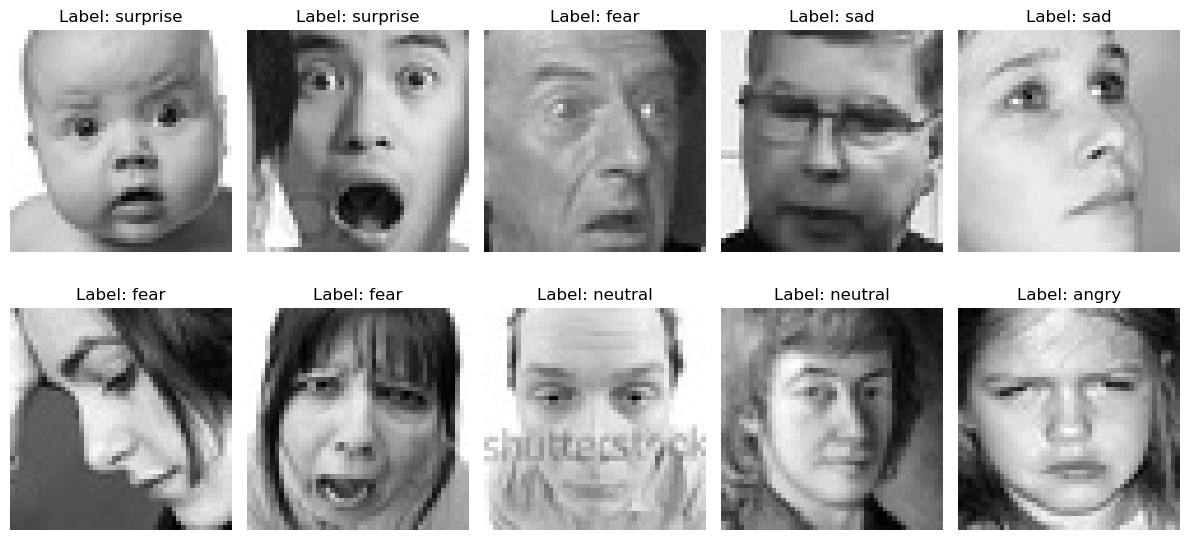

In [9]:
# 10 Beispiele plotten
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, len(test_images) - 1)
    ax = axes[i // 5, i % 5]
    ax.imshow(test_images[random_index].squeeze(), cmap='gray')
    ax.set_title(f"Label: {reverse_label_mapping[test_labels[random_index].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Vorhersagen auf den Testdaten mit allen drei Modellen machen

Wir werden die Vorhersagen der drei Modelle auf den Testdaten machen. Diese vergleichen wir dann mit den tatsächlichen Labels, um im nächsten Abschnitt die Performance der Modelle zu evaluieren.
Da wir die Trainingsdaten normalisiert haben, werden wir auch die Testdaten normalisieren, bevor wir die Vorhersagen machen.

In [10]:
# Testdaten normalisieren
test_images_tensors = test_images.float() / 255.0

model_1_predictions = model_1(test_images_tensors)
model_2_predictions = model_2(test_images_tensors)
model_3_predictions = model_3(test_images_tensors)

list_of_predictions = [model_1_predictions, model_2_predictions, model_3_predictions]

### Aufgabe 2: Accuracy
Wir führen hier nochmals die Accuracy der Modelle auf. 
Um eine Indikation zu bekommen, wie gut die Modelle auf den Testdaten performen. Im darauf folgenden Abschnitt versuchen wir, die Performance der Modelle genauer zu evaluieren.
Je nach Anforderung an unser Modell, könnte die Accuracy alleine nicht ausreichend sein, um die Performance zu beurteilen. Daher werden wir im nächsten Abschnitt weitere Metriken berechnen.

**Fragen**:
1. Welches Modell würden Sie aufgrund der Accuracy bevorzugen?
> Individuell von Ihren MOdellen abhängig. Hier Modell 2.

2. Was könnte ein Problem sein, wenn man die Accuracy als einzige Metrik zur Beurteilung der Performance eines Modells verwendet?
> Die Accuracy alleine könnte irreführend sein, insbesondere wenn die Klassen unausgeglichen sind. Wenn eine Klasse viel häufiger vorkommt als andere, könnte ein Modell eine hohe Accuracy erreichen, indem es einfach immer die häufigste Klasse vorhersagt, ohne tatsächlich die anderen Klassen gut zu klassifizieren. Daher ist es wichtig, weitere Metriken wie Precision, Recall und F1-Score pro Klasse zu betrachten, um ein umfassenderes Bild der Modellperformance zu erhalten.

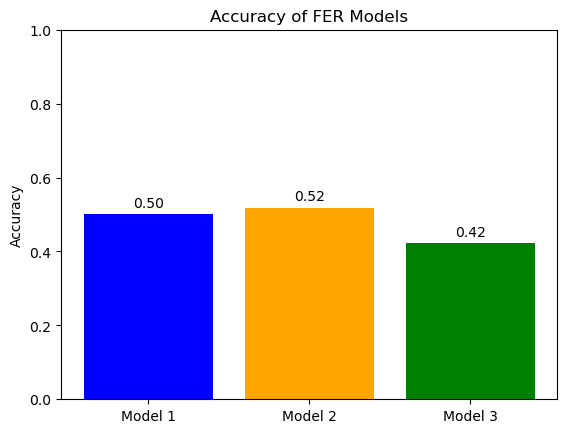

In [26]:
model_1_accuracy = (model_1_predictions.argmax(dim=1) == test_labels).float().mean().item()
model_2_accuracy = (model_2_predictions.argmax(dim=1) == test_labels).float().mean().item()
model_3_accuracy = (model_3_predictions.argmax(dim=1) == test_labels).float().mean().item()
model_metrics_list = [
    {"Model": "Model 1", "Accuracy": model_1_accuracy},
    {"Model": "Model 2", "Accuracy": model_2_accuracy},
    {"Model": "Model 3", "Accuracy": model_3_accuracy},
]

plt.Figure(figsize=(8, 4))
model_names = [metrics["Model"] for metrics in model_metrics_list]
accuracies = [metrics["Accuracy"] for metrics in model_metrics_list]
#add the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha='center', va='bottom')
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy of FER Models")
plt.show()


## Auswertungen der Modelle

Bis anhin haben wir die Modelle nur anhand der Accuracy ausgewertet.
In diesem Abschnitt werden wir weitere Metriken berechnen, um die Performance der Modelle genauer zu untersuchen. Dazu gehören die **Precision**, **Recall** und **F1-Score**. Ausserdem werden wir die **Confusion-Matrix** berechnen und visualisieren, um zu sehen, welche Klassen von den Modellen am häufigsten verwechselt werden.

Wir werden diese Metriken einzeln behandeln und dann in einem Vergleich zusammenfassen. Wir berechnen die Metriken für jedes Modell und jede Klasse separat, um zu sehen, wie gut die Modelle in Bezug auf jede Emotion abschneiden.
Um diese Metriken zu berechnen müssen wir noch die Begriffe **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)** und **False Negatives (FN)** definieren. Diese Begriffe beziehen sich auf die Anzahl der korrekt und falsch klassifizierten Datenpunkte für jede Klasse.

### True Positives, False Positives, True Negatives und False Negatives

- **True Positives (TP)**: Anzahl der Datenpunkte, die korrekt als eine bestimmte Klasse klassifiziert wurden.
- **False Positives (FP)**: Anzahl der Datenpunkte, die fälschlicherweise als eine bestimmte Klasse klassifiziert wurden.
- **True Negatives (TN)**: Anzahl der Datenpunkte, die korrekt als nicht zu einer bestimmten Klasse gehörend klassifiziert wurden.
- **False Negatives (FN)**: Anzahl der Datenpunkte, die fälschlicherweise als nicht zu einer bestimmten Klasse gehörend klassifiziert wurden.

Da wir die TP, FP, TN und FN für die verschiedenen Metriken benötigen, werden wir diese zuerst einzeln pro Modell und Klasse berechnen.
Wir erstellen ein Pandasp DataFrame, um diese Werte für jedes Modell und jede Klasse zu speichern. Dies erleichtert die Berechnung der Metriken im nächsten Schritt.

In [11]:
model_1_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])
model_2_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])
model_3_metrics = pd.DataFrame(columns=["Class", "TP", "FP", "TN", "FN"])

model_metrics_list = [model_1_metrics, model_2_metrics, model_3_metrics]

for class_index in range(7):
    for model_index in range(len(model_metrics_list)):
        # Berechnung der Metriken für Modell 1
        model_predicted_labels = torch.argmax(list_of_predictions[model_index], dim=1)
        TP_1 = ((model_predicted_labels == class_index) & (test_labels == class_index)).sum().item()
        FP_1 = ((model_predicted_labels == class_index) & (test_labels != class_index)).sum().item()
        TN_1 = ((model_predicted_labels != class_index) & (test_labels != class_index)).sum().item()
        FN_1 = ((model_predicted_labels != class_index) & (test_labels == class_index)).sum().item()
        model_metrics_list[model_index].loc[class_index] = [reverse_label_mapping[class_index], TP_1, FP_1, TN_1, FN_1]

        

In [16]:
for model_metrics in model_metrics_list:
    print(model_metrics)
    print("\n")

      Class    TP   FP    TN   FN
0     angry   403  671  5549  555
1   disgust    34   41  7026   77
2      fear   346  706  5448  678
3     happy  1396  703  4701  378
4       sad   484  777  5154  763
5  surprise   435  167  6180  396
6   neutral   504  511  5434  729


      Class    TP   FP    TN   FN
0     angry   365  538  5682  593
1   disgust    50   33  7034   61
2      fear   396  533  5621  628
3     happy  1208  508  4896  566
4       sad   515  758  5173  732
5  surprise   595  307  6040  236
6   neutral   595  777  5168  638


      Class    TP    FP    TN   FN
0     angry   141   271  5949  817
1   disgust     5     8  7059  106
2      fear   179   423  5731  845
3     happy  1254  1170  4234  520
4       sad   312   564  5367  935
5  surprise   438   392  5955  393
6   neutral   709  1312  4633  524




Nachdem wir die die einzelnen Werte für TP, FP, TN und FN berechnet haben, können wir die Metriken für jedes Modell und jede Klasse berechnen. Wir werden die Metriken in einem weiteren DataFrame speichern, um sie später zu vergleichen.

### Aufgabe 3: Fragen zu TP, FP, TN und FN

1. Nennen Sie ein Beispiel für ein Modell, bei welchem eine hohe Anzahl von False Positives problematisch sein könnte. Erklären Sie kurz, warum das so ist.
> Ein Beispiel könnte ein medizinisches Diagnosemodell sein, das eine Krankheit vorhersagt. Eine hohe Anzahl von False Positives könnte problematisch sein, weil es zu unnötigen Behandlungen, Angst und Kosten für die Patienten führen könnte. Wenn das Modell fälschlicherweise eine Krankheit vorhersagt, könnte dies zu unnötigen medizinischen Tests oder Behandlungen führen, die nicht nur teuer, sondern auch belastend für die Patienten sein können.

2. Was wäre ein Beispiel für ein Modell, bei welchem eine hohe Anzahl von False Negatives problematisch sein könnte? Erklären Sie kurz, warum das so ist.
> Ein Beispiel wäre ein Spam-Filter, der E-Mails als Spam klassifiziert. Bei einer hochen Anzahl an False-Negatives kommen viele Spam-E-Mails im Posteingang an, was zu Unannehmlichkeiten und möglicherweise zu Sicherheitsrisiken führen könnte, wenn schädliche E-Mails nicht erkannt werden.

### Metriken berechnen

|Metrik|Definition|Beschreibung|
|---|---|---|
|**Precision:**| $Precision = \frac{TP}{TP + FP}$ | Die Precision beziffert, wie viele der Data Samples, die als eine bestimmte Klasse klassifiziert wurden, tatsächlich zu dieser Klasse gehören. Eine hohe Precision bedeutet, dass unser Modell wenige False Positives für eine Klasse hat.|
|**Recall:**| $Recall = \frac{TP}{TP + FN}$ | Der Recall beziffert, wie viele der Data Samples, die tatsächlich zu einer bestimmten Klasse gehören, korrekt als diese Klasse klassifiziert wurden. Ein hoher Recall bedeutet, dass unser Modell wenige False Negatives für eine Klasse hat.|
|**F1-Score:**| $F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ | Der F1-Score ist sozusagen ein Mittelwert von Precision und Recall. Er gibt uns eine einzige Metrik, die sowohl die Precision als auch den Recall berücksichtigt. Ein hoher F1-Score bedeutet, dass unser Modell sowohl eine hohe Precision als auch einen hohen Recall hat.

In [13]:
df_metrics = pd.DataFrame(columns=["Model", "Class", "Precision", "Recall", "F1-Score"])

for model_index in range(len(model_metrics_list)):
    for index, row in model_metrics_list[model_index].iterrows():
        TP = row["TP"]
        FP = row["FP"]
        TN = row["TN"]
        FN = row["FN"]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        df_metrics.loc[len(df_metrics)] = [f"Model {model_index + 1}", row["Class"], precision, recall, f1_score]

In [14]:
df_metrics

,Model,Class,Precision,Recall,F1-Score
0,Model 1,angry,0.375233,0.420668,0.396654
1,Model 1,disgust,0.453333,0.306306,0.365591
2,Model 1,fear,0.328897,0.337891,0.333333
3,Model 1,happy,0.665079,0.786922,0.720888
4,Model 1,sad,0.383822,0.388132,0.385965
5,Model 1,surprise,0.722591,0.523466,0.607118
6,Model 1,neutral,0.496552,0.408759,0.448399
7,Model 2,angry,0.404208,0.381002,0.392262
8,Model 2,disgust,0.602410,0.450450,0.515464
9,Model 2,fear,0.426265,0.386719,0.405530


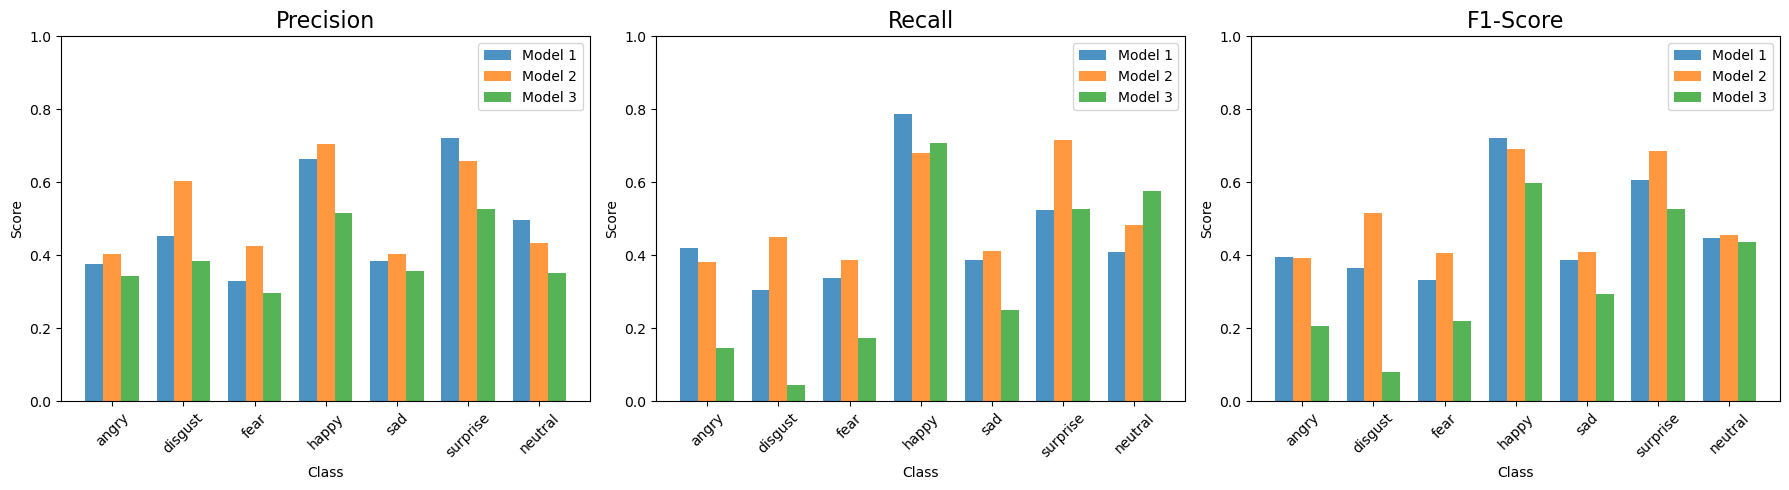

In [23]:
#plot der Metriken

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["Precision", "Recall", "F1-Score"]

for metric_index, metric in enumerate(metrics):
    for model_index in range(1, 4):
        model_data = df_metrics[df_metrics["Model"] == f"Model {model_index}"]
        axs[metric_index].bar(
            [i + (model_index - 1) * 0.25 for i in range(7)],
            model_data[metric].values,
            width=0.25,
            label=f"Model {model_index}",
            alpha=0.8
        )
    
    axs[metric_index].set_title(f"{metric}")
    axs[metric_index].title.set_fontsize(16)
    axs[metric_index].set_ylabel("Score")
    axs[metric_index].set_xlabel("Class")
    axs[metric_index].set_xticks([i + 0.25 for i in range(7)])
    axs[metric_index].set_xticklabels([reverse_label_mapping[i] for i in range(7)], rotation=45)
    axs[metric_index].legend()
    axs[metric_index].set_ylim([0, 1])

plt.tight_layout()
plt.show()


### Confusion-Matrix visualisieren

Die Confusion Matrix ist eine Tabelle, die die Anzahl der korrekt und falsch klassifizierten Datenpunkte für jede Klasse zeigt. Sie gibt uns einen Überblick darüber, welche Klassen von den Modellen am häufigsten verwechselt werden.
Somit erhalten wir einen genaueren Einblick in die Klassen und mit welchen Klassen z.B. eine bestimmte Klasse am häufigsten verwechselt wird (deshalb Confusion Matrix). 
Dies kann uns helfen die Stärken und Schwächen der Modelle zu verstehen und mögliche Verbesserungen zu identifizieren.

Da es bereits bereits vorgefertigte Funktionen gibt, welche die Confusion Matrix berechnen, nutzen wir diese.

Die Werte wurden normalisiert, damit wir die Werte besser vergleichen können. Das bedeutet, dass die Werte aller Predicions für eine Klasse aufsummiert 1 ergeben. Somit können wir die Werte besser vergleichen, da die Anzahl der Datenpunkte pro Klasse unterschiedlich ist.

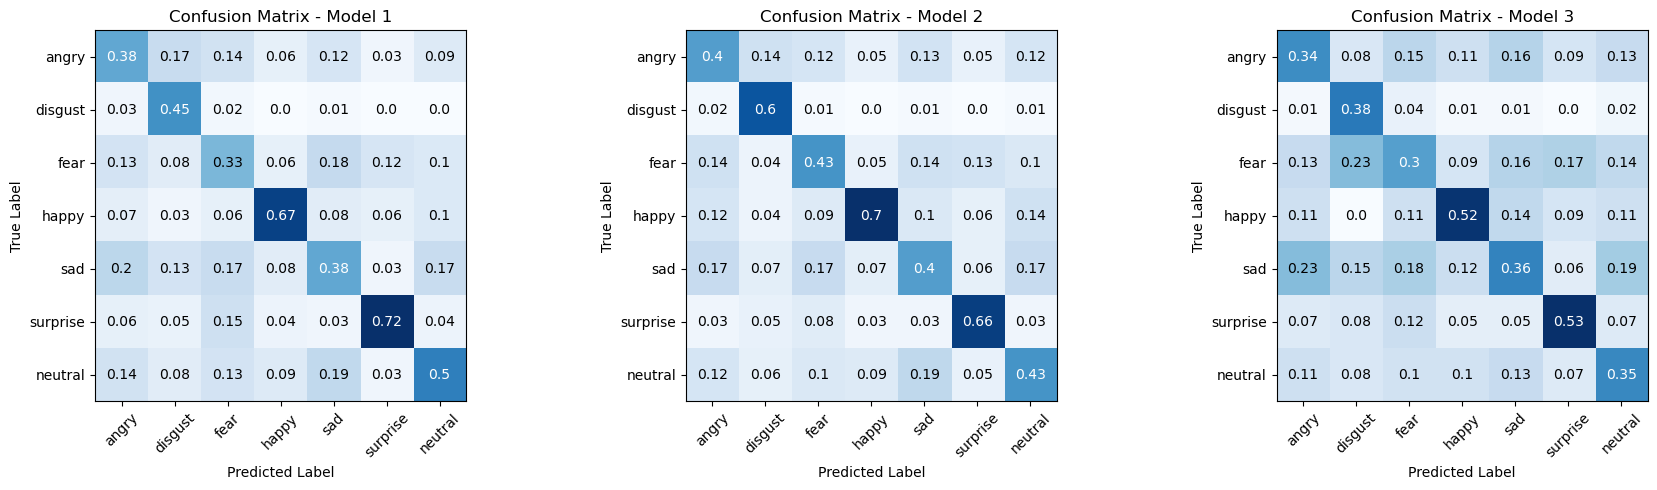

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for model_index in range(3):
    # Prediction Labels auslesen
    predicted_labels = torch.argmax(list_of_predictions[model_index], dim=1).numpy()
    
    # Confusion Matrix berechnen und normalisieren
    cm = confusion_matrix(test_labels.numpy(), predicted_labels, labels=list(range(7)), normalize='pred')
    
    #round the values in the confusion matrix to 2 decimal places
    cm = np.round(cm, 2)

    # Plot confusion matrix
    im = axes[model_index].imshow(cm, cmap='Blues')
    axes[model_index].set_title(f"Confusion Matrix - Model {model_index + 1}")
    axes[model_index].set_xlabel('Predicted Label')
    axes[model_index].set_ylabel('True Label')
    axes[model_index].set_xticks(range(7))
    axes[model_index].set_yticks(range(7))
    axes[model_index].set_xticklabels([reverse_label_mapping[i] for i in range(7)], rotation=45)
    axes[model_index].set_yticklabels([reverse_label_mapping[i] for i in range(7)])
    
    # Add text annotations
    for i in range(7):
        for j in range(7):
            axes[model_index].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

#### Aufgabe 4: Fragen zur Confusion Matrix

1. Gibt es bei ihren Modellen eine Klasse, welche häufig verwechselt wird? Wenn ja, welche Klasse ist das und mit welcher Klasse wird sie am häufigsten verwechselt?
> Individuell von Ihren Modellen abhängig. Hier z.B. in Modell_1: 19% der Predictions für Sad sind eigentlich Neutral und umgekehrt waren 17% der Predictions für Neutral eigentlich Sad.

2. Welche Klassen werden am besten klassifiziert?
> Die Klasse "Happy" und "Surprise" werden von allen Modellen am besten klassifiziert.


## Aufgabe 5: Kontrollfragen

### Frage 1: Accuracy vs. balancierte Metriken
Stellen Sie sich vor, Sie entwickeln ein Modell zur Erkennung von Emotionen für eine Therapie-App. In Ihrem Trainingsdatensatz sind 85% der Bilder "Happy" und nur 15% sind auf die anderen 6 Emotionen verteilt. Ihr Modell erreicht eine Accuracy von 82%. Erklären Sie, warum diese hohe Accuracy täuschend sein könnte und welche Metriken Sie zusätzlich betrachten sollten, um die tatsächliche Leistung des Modells zu beurteilen.

> Die hohe Accuracy könnte täuschend sein, weil das Modell möglicherweise einfach immer "Happy" vorhersagt, um eine hohe Accuracy zu erreichen, ohne tatsächlich die anderen Emotionen gut zu klassifizieren. In diesem Fall würde das Modell 85% der Bilder korrekt klassifizieren (die "Happy" Bilder), aber es würde die anderen Emotionen schlecht klassifizieren. Daher sollten zusätzlich Metriken wie Precision, Recall und F1-Score pro Klasse betrachtet werden, um ein umfassenderes Bild der Modellperformance zu erhalten.

### Frage 2: Trade-off zwischen Precision und Recall

Angenommen, Sie haben zwei Modelle für die Klassifizierung von Produkten in einem Online-Shop entwickelt, die Produkte in die Kategorie "Premium" einordnen sollen. Die beiden Modelle haben folgende Performance:
- **Modell A**: Hohe Precision (0.95) aber niedriger Recall (0.60) für die Kategorie "Premium"
- **Modell B**: Niedrigere Precision (0.70) aber hoher Recall (0.92) für die Kategorie "Premium"

Diskutieren Sie, in welchen Anwendungsszenarien Sie Modell A bzw. Modell B bevorzugen würden. Begründen Sie Ihre Antwort mit konkreten Beispielen.

> **Modell A (Hohe Precision, niedriger Recall)**: Dieses Modell wäre vorzuziehen, wenn die Kosten für False Positives hoch sind. Beispiel: Ein Einzelhändler möchte Premium-Produkte in einem exklusiven Katalog präsentieren. Wenn ein normales Produkt fälschlicherweise als Premium klassifiziert wird, könnte das den Ruf der Shops schädigen. Die hohe Precision stellt sicher, dass nur wirklich Premium-Produkte ausgewählt werden, auch wenn einige echte Premium-Produkte übersehen werden.
>
> **Modell B (Niedrigere Precision, hoher Recall)**: Dieses Modell wäre besser, wenn die Kosten für False Negatives hoch sind. Beispiel: Ein Online-Shop möchte sicherstellen, dass alle Premium-Produkte in einer speziellen Werbekampagne beworben werden. In diesem Fall wäre es wichtiger, möglichst viele echte Premium-Produkte zu erfassen (hoher Recall), auch wenn einige normale Produkte fälschlicherweise als Premium klassifiziert werden (niedrigere Precision).

### Frage 3: Interpretation der Confusion Matrix
In der Confusion Matrix eines Ihrer Modelle sehen Sie, dass die Emotionen "Sad" und "Neutral" häufig miteinander verwechselt werden. Erklären Sie, welche möglichen Gründe es dafür geben könnte (denken Sie sowohl an Daten- als auch an Modellaspekte).
> Mögliche Gründe für die Verwechslung von "Sad" und "Neutral" könnten sein:
> - Es könnte sein, dass die Bilder in den Klassen "Sad" und "Neutral" sehr ähnlich aussehen, z.B. durch ähnliche Gesichtsausdrücke oder Beleuchtung. 
> - Es könnte auch sein, dass es nicht genügend Trainingsdaten für diese Klassen gibt, was zu einer schlechten Generalisierung führt.
> - Das Modell könnte Schwierigkeiten haben, feine Unterschiede zwischen den beiden Klassen zu erkennen, insbesondere wenn die Architektur nicht komplex genug ist oder wenn die Hyperparameter nicht optimal eingestellt sind.

### Frage 4: False Positives vs. False Negatives im Kontext
Stellen Sie sich vor, Sie entwickeln ein Betrugserkennnungssystem für eine Bank, das verdächtige Transaktionen identifiziert ("Betrug" = True, "Legitim" = False). Bewerten Sie, was in diesem Kontext problematischer ist: Eine hohe Rate an False Positives oder eine hohe Rate an False Negatives? Begründen Sie Ihre Antwort unter Berücksichtigung der praktischen Konsequenzen.

> **False Negatives sind in diesem Kontext problematischer.** False Negatives bedeuten, dass betrügerische Transaktionen nicht erkannt werden und die Bank sowie ihre Kunden finanziellen Schaden erleiden. Dies könnte zu Verlusten, Reputationsschäden und regulatorischen Konsequenzen führen.
>
> **False Positives**: Dies bedeutet, dass legitime Transaktionen fälschlicherweise als betrügerisch markiert werden. Dies könnte zu Unannehmlichkeiten für die Kunden führen, wie z.B. blockierte Karten. Ausserdem können viele False Positives zu hohem manuellem Aufwand seitens der Bank führen, um diese Transaktionen zu überprüfen.
>
> Dies bedeutet, dass es eine Abwägung nötig macht, welche das Risiko von Betrugstransaktionen miteinbezieht und die Kundenzufriedenheit berücksichtigt. Eine Abschätzung der Folgekosten von False Positives und False Negatives könnte helfen, die optimale Balance zu finden.

### Frage 6: Bedeutung der Normalisierung und Evaluation
Im Notebook werden sowohl die Trainings- als auch die Testdaten normalisiert (Division durch 255.0). Stellen Sie eine Vermutung an, was passieren würde, wenn man das Modell auf nicht normalisierten Testdaten evaluieren würde, obwohl es auf normalisierten Trainingsdaten trainiert wurde. Begründen Sie Ihre Antwort.
> Wenn das Modell auf nicht normalisierten Testdaten evaluiert wird, obwohl es auf normalisierten Trainingsdaten trainiert wurde, könnte die Performance des Modells drastisch sinken. Das liegt daran, dass die Werte der Pixel in den Testdaten im Bereich von 0-255 liegen, während die Werte in den Trainingsdaten im Bereich von 0-1 liegen. Das Modell hat gelernt, Muster und Merkmale basierend auf den normalisierten Daten zu erkennen. Wenn es nun mit unnormalisierten Daten konfrontiert wird, wird es wahrscheinlich Schwierigkeiten haben, die relevanten Merkmale zu erkennen, da die Werte viel höher sind als erwartet.

